In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
import os

In [4]:
data = pd.read_csv('solarenergy.csv', delimiter=',', parse_dates = ['Datetime'])

print('*' * 20, 'Data Preview: ', '*' * 20,'\n', data.head(), '\n', '****' * 20)
print('*' * 20, 'Data Describtion: ', '*' * 20,'\n', data.describe(), '\n', '****' * 20)
print('*' * 20, 'Data Shape: ', '*' * 20,'\n', data.shape, '\n', '****' * 20)

******************** Data Preview:  ******************** 
              Datetime  solar_mw  wind-direction  wind-speed  humidity  \
0 2020-03-08 12:00:00     11385            27.0         7.5      75.0   
1 2020-02-08 11:00:00     12390            27.0         7.5      77.0   
2 2020-02-08 10:00:00     13312            27.0         7.5      70.0   
3 2020-02-08 09:00:00     13832            27.0         7.5      33.0   
4 2020-02-08 08:00:00     14038            27.0         7.5      21.0   

   average-wind-speed-(period)  average-pressure-(period)  temperature  
0                          8.0                      29.82         69.0  
1                          5.0                      29.85         69.0  
2                          0.0                      29.89         69.0  
3                          0.0                      29.91         69.0  
4                          3.0                      29.89         69.0   
 **************************************************************

In [5]:
data.dtypes

Datetime                       datetime64[ns]
solar_mw                                int64
wind-direction                        float64
wind-speed                            float64
humidity                              float64
average-wind-speed-(period)           float64
average-pressure-(period)             float64
temperature                           float64
dtype: object

In [6]:
data.isna().sum()

Datetime                            0
solar_mw                            0
wind-direction                 113198
wind-speed                     113197
humidity                       113197
average-wind-speed-(period)    113198
average-pressure-(period)      113197
temperature                    113197
dtype: int64

In [7]:
data.fillna(data.mean(), inplace=True)

<ipython-input-7-a20208f658ce>:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



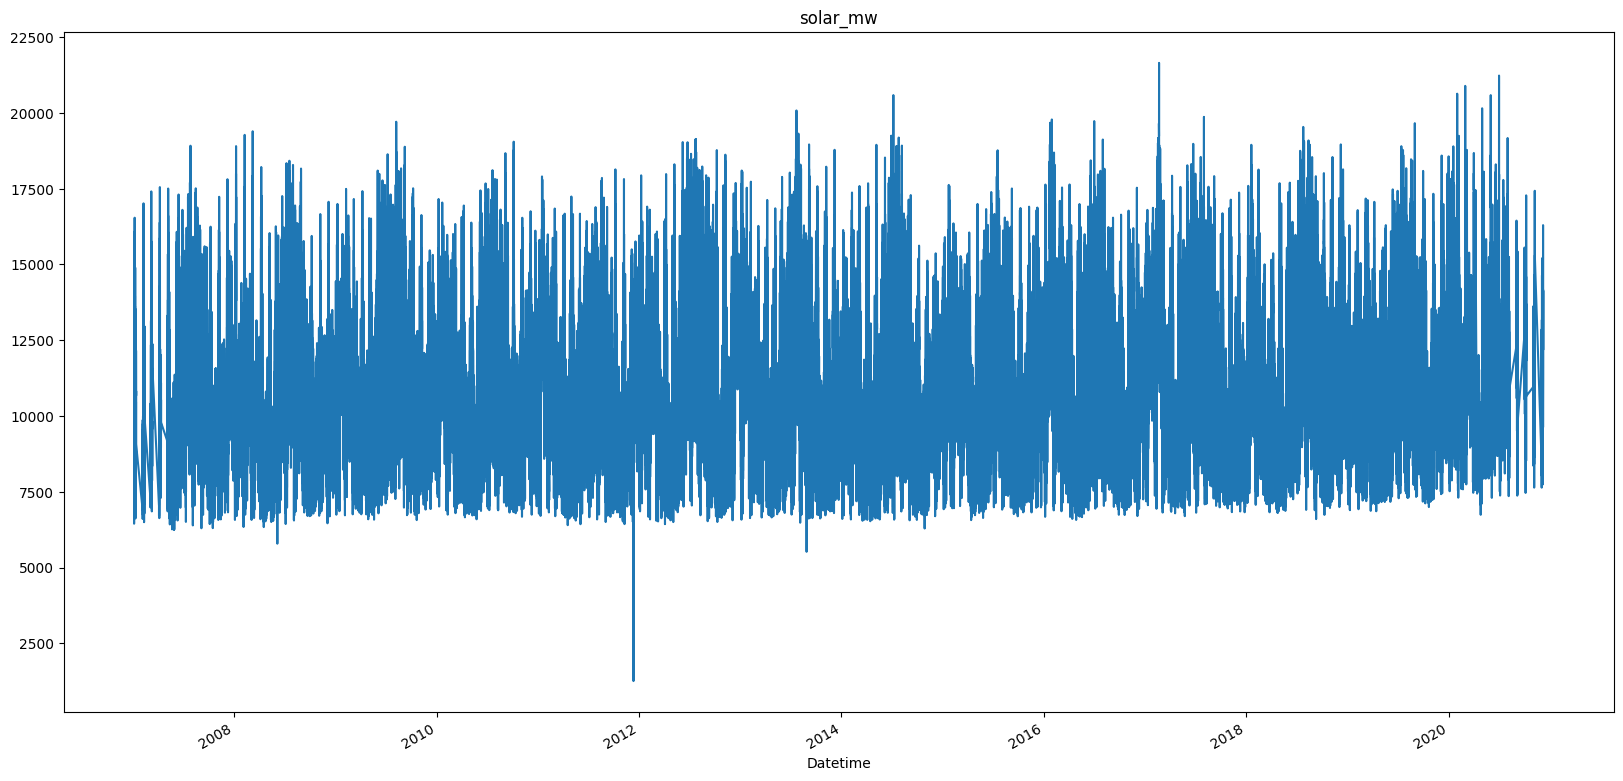

In [8]:
data = data.set_index('Datetime')
data['solar_mw'].plot(title='solar_mw', figsize=(20,10));

,wind-direction,wind-speed,humidity,average-wind-speed-(period),average-pressure-(period),temperature
wind-direction,1.000000,0.128805,-0.066051,0.082821,-0.154994,0.241200
wind-speed,0.128805,1.000000,0.004901,0.673364,-0.379752,0.096267
humidity,-0.066051,0.004901,1.000000,-0.217959,0.018489,-0.221463
average-wind-speed-(period),0.082821,0.673364,-0.217959,1.000000,-0.293406,0.054545
average-pressure-(period),-0.154994,-0.379752,0.018489,-0.293406,1.000000,-0.435723
temperature,0.241200,0.096267,-0.221463,0.054545,-0.435723,1.000000


<Axes: >

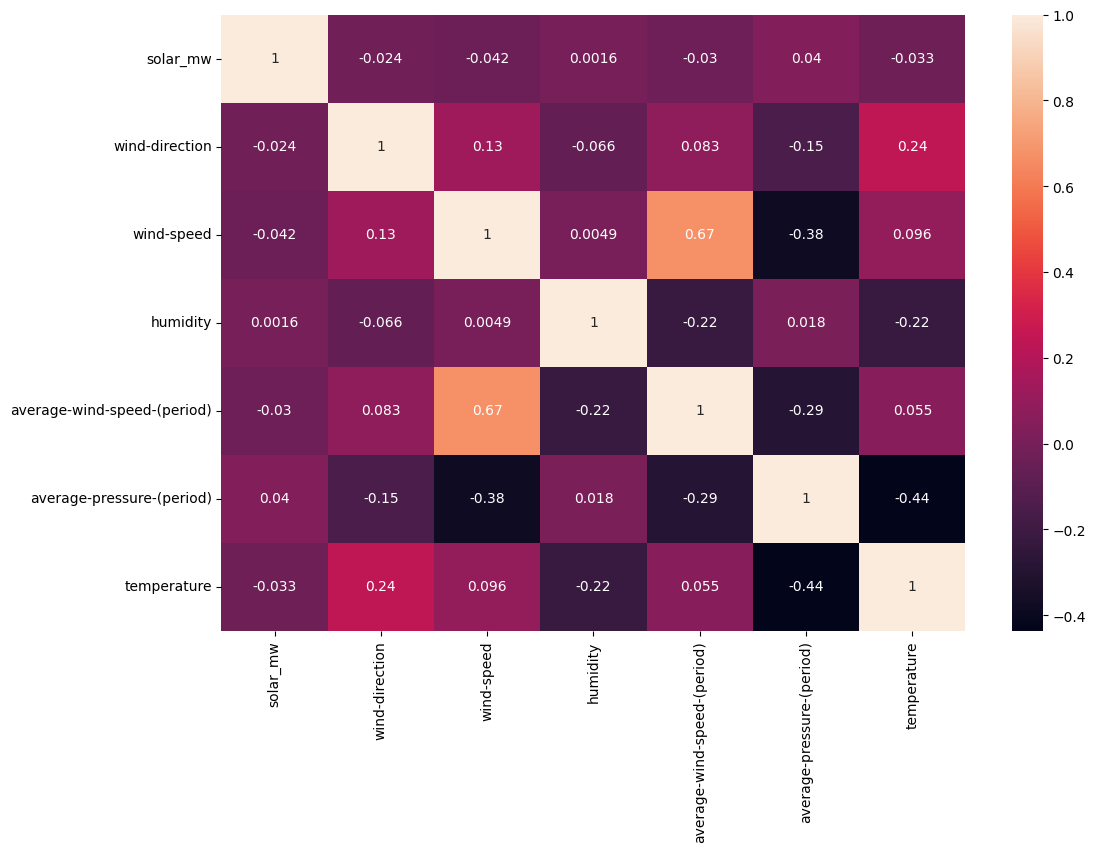

In [9]:
import seaborn as sns
display(data.iloc[:,1:].corr())
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(),annot=True)

In [10]:
def convert_data(data, look_back = 1, dropnan=True):
    df = data
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(look_back, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]

    # forecast (t) only for electricity(label/class)
    cols.append(df.shift(0)['solar_mw'])
    names += ['solar_mw(t)']

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg



In [11]:
look_back = 12
dataset = convert_data(data = data, look_back = look_back, dropnan=True)

In [12]:
dataset.head()

,solar_mw(t-12),wind-direction(t-12),wind-speed(t-12),humidity(t-12),average-wind-speed-(period)(t-12),average-pressure-(period)(t-12),temperature(t-12),solar_mw(t-11),wind-direction(t-11),wind-speed(t-11),...,average-pressure-(period)(t-2),temperature(t-2),solar_mw(t-1),wind-direction(t-1),wind-speed(t-1),humidity(t-1),average-wind-speed-(period)(t-1),average-pressure-(period)(t-1),temperature(t-1),solar_mw(t)
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-08 12:00:00,11385.0,27.0,7.5,75.0,8.0,29.82,69.0,12390.0,27.0,7.5,...,29.90,72.0,15191.0,28.0,6.8,64.0,0.0,29.92,72.0,14666
2020-02-08 11:00:00,12390.0,27.0,7.5,77.0,5.0,29.85,69.0,13312.0,27.0,7.5,...,29.92,72.0,14666.0,28.0,6.8,23.0,9.0,29.88,72.0,13966
2020-02-08 10:00:00,13312.0,27.0,7.5,70.0,0.0,29.89,69.0,13832.0,27.0,7.5,...,29.88,72.0,13966.0,28.0,6.8,30.0,18.0,29.84,72.0,13232
2020-02-08 09:00:00,13832.0,27.0,7.5,33.0,0.0,29.91,69.0,14038.0,27.0,7.5,...,29.84,72.0,13232.0,28.0,6.8,65.0,11.0,29.84,72.0,12555
2020-02-08 08:00:00,14038.0,27.0,7.5,21.0,3.0,29.89,69.0,14453.0,27.0,7.5,...,29.84,72.0,12555.0,28.0,6.8,75.0,5.0,29.85,72.0,11850


In [13]:
def create_dataset(data, look_back):
  dataset = convert_data(data = data, look_back = look_back, dropnan=True)
  dataset = dataset.astype('float32')

  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)

  # split into train and test sets
  train_size = int(len(dataset) * 0.70)
  test_size = len(dataset) - train_size
  X_train, y_train, X_test, y_test = dataset[0:train_size,0:-1], dataset[0:train_size,-1], \
                dataset[-test_size:,0:-1], dataset[-test_size:,-1]

  # reshape input to be [samples, time steps, features]
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  return X_train, y_train, X_test, y_test

look_back = 12
X_train, y_train, X_test, y_test = create_dataset(data, look_back)

In [14]:
X_train.shape[0] + X_test.shape[0]

116105

In [15]:

class linearRegression(nn.Module):
  def __init__(self,input_dim):
    super(linearRegression,self).__init__()  # building connection with parent and child classes
    self.fc1=nn.Linear(input_dim,10)          # hidden layer 1
    self.fc2=nn.Linear(10,5)                  # hidden layer 2
    self.fc3=nn.Linear(5,3)                   # hidden layer 3
    self.fc4=nn.Linear(3,1)                   # last layer

  def forward(self,d):
    out=torch.relu(self.fc1(d))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(out))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(out))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome



In [16]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('T4')
else:
    device = torch.device("cpu")


model = linearRegression(input_dim = X_train_tensors.shape[2])
model.to(device)
print(model)

T4
linearRegression(
  (fc1): Linear(in_features=84, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=1, bias=True)
)


In [ ]:
X_train_tensors.shape

torch.Size([76255, 1, 84])

In [18]:
X_train_tensors = X_train_tensors.to(device)
y_train_tensors = y_train_tensors.to(device)

X_test_tensors = X_test_tensors.to(device)
y_test_tensors = y_test_tensors.to(device)

In [19]:
# select loss and optimizers

loss=nn.MSELoss() # loss function
optimizers=torch.optim.Adam(params=model.parameters(),lr=0.01)

# training the model:
train_loss = []
val_loss = []
num_of_epochs=1000
for i in range(num_of_epochs):
  optimizers.zero_grad() # make gradients zero for every iteration so next iteration it will be clear
  # give the input data to the architecure
  y_train_prediction = model(X_train_tensors)  # model initilizing
  loss_value = loss(y_train_prediction.squeeze(),y_train_tensors)   # find the loss function:
  train_loss.append(loss_value.item())
  loss_value.backward()  # back propagation
  optimizers.step()  # update weights in NN

  #validation
  #val_out = model.forward(X_test_tensors)
  #loss_val = loss(val_out, y_test_tensors)
  #val_loss.append(loss_val.item())

  # print the loss in training part:
  if i % 50 == 0:
    print(f'[epoch:{i}]: The loss value for training part={loss_value}')

[epoch:0]: The loss value for training part=0.021728118881583214
[epoch:50]: The loss value for training part=0.00519372196868062
[epoch:100]: The loss value for training part=0.001985225360840559
[epoch:150]: The loss value for training part=0.001249454915523529
[epoch:200]: The loss value for training part=0.001299648662097752
[epoch:250]: The loss value for training part=0.0009217474143952131
[epoch:300]: The loss value for training part=0.0028290303889662027
[epoch:350]: The loss value for training part=0.000770648242905736
[epoch:400]: The loss value for training part=0.0008300105109810829
[epoch:450]: The loss value for training part=0.0012672115117311478
[epoch:500]: The loss value for training part=0.0006767315207980573
[epoch:550]: The loss value for training part=0.0005943150026723742
[epoch:600]: The loss value for training part=0.0005476311780512333
[epoch:650]: The loss value for training part=0.0005951178027316928
[epoch:700]: The loss value for training part=0.0006214975

Text(0, 0.5, 'MSE loss')

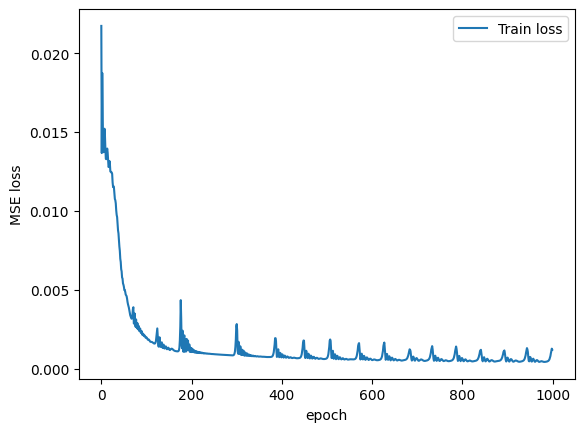

In [20]:
#plotting
plt.plot( train_loss, label = "Train loss")
#plt.plot(val_loss, label = "Validation loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [21]:
# we can do check it with test data:

with torch.no_grad():
  model.eval()   # make model in evaluation stage
  y_test_prediction=model(X_test_tensors)
  test_loss=loss(y_test_prediction.squeeze(),y_test_tensors)
  print(f'Test loss value : {test_loss.item():.4f}')
# Inference with own data:
pr = torch.tensor(torch.arange(1, 101).unsqueeze(dim=0), dtype=torch.float32).clone().detach()
print(pr)


Test loss value : 0.0010
tensor([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
          13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
          25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
          37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
          49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
          61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
          73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
          85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
          97.,  98.,  99., 100.]])


<ipython-input-21-f89da2b9e2f3>:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [22]:
dataset.shape

(116105, 85)

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))

y_real = dataset.iloc[0:,0].to_numpy()
print(y_real.shape)

x=scaler.fit_transform(y_real.reshape(1,-1))

(116105,)


In [24]:
train_predict = model.forward(X_train_tensors) #forward pass
train_predict = train_predict.cpu().detach().numpy()

test_predict = model.forward(X_test_tensors) #forward pass
test_predict = test_predict.cpu().detach().numpy()

In [25]:
y_hat = np.append(train_predict, test_predict).reshape(1,-1)
print(y_hat.shape)

y_hat = scaler.inverse_transform(y_hat).reshape(-1,1) #reverse transformation

(1, 116105)


In [26]:
data.shape

(116117, 7)

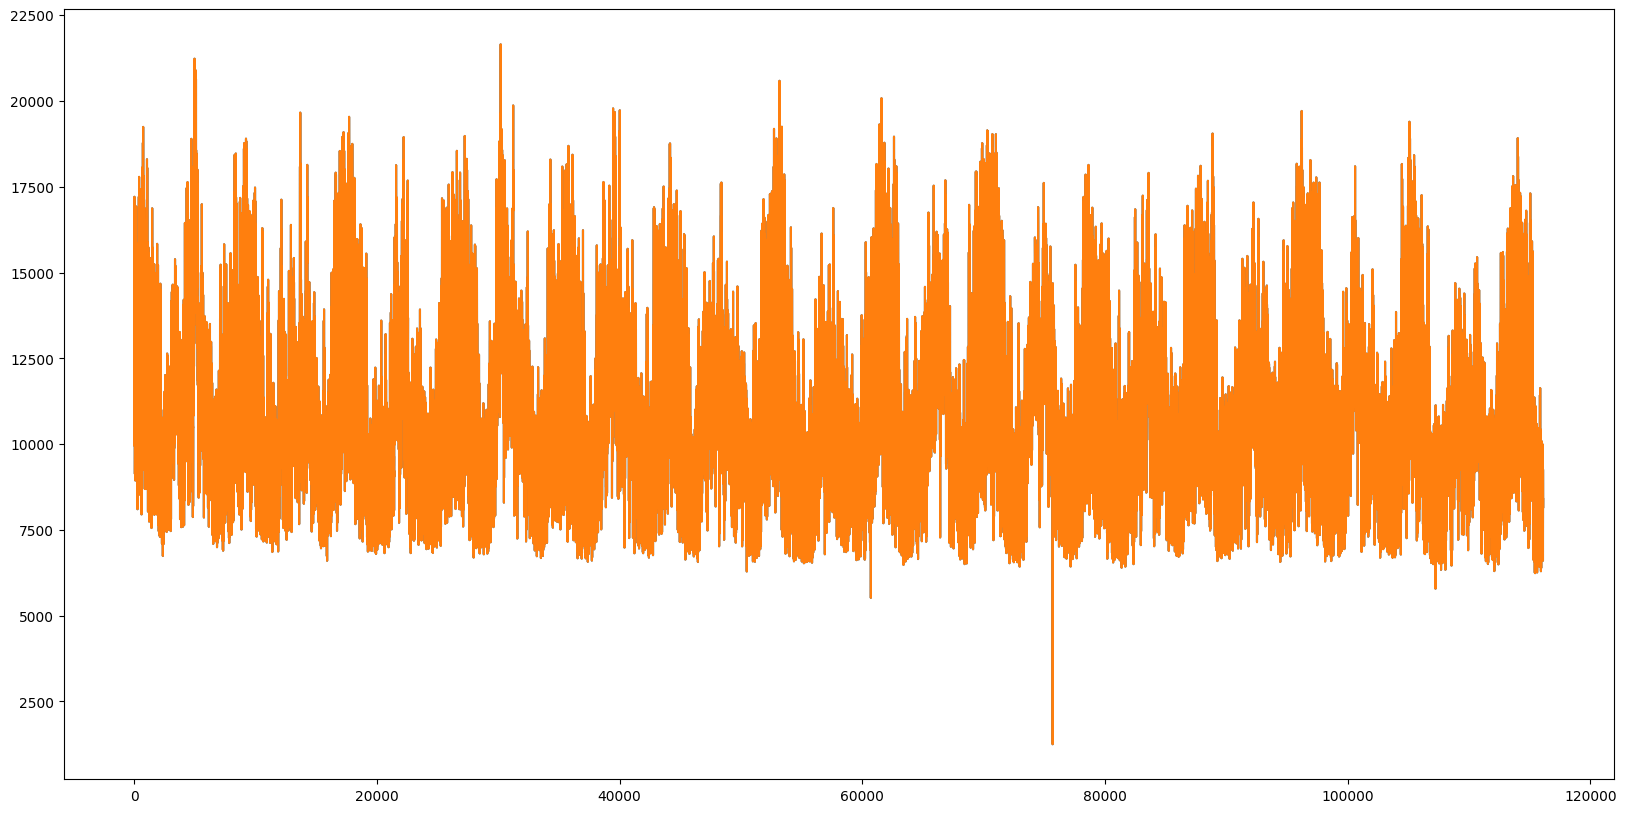

In [27]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real, label='Actuall Data') #actual plot

plt.plot(y_hat, label='Predicted Data') #predicted plot

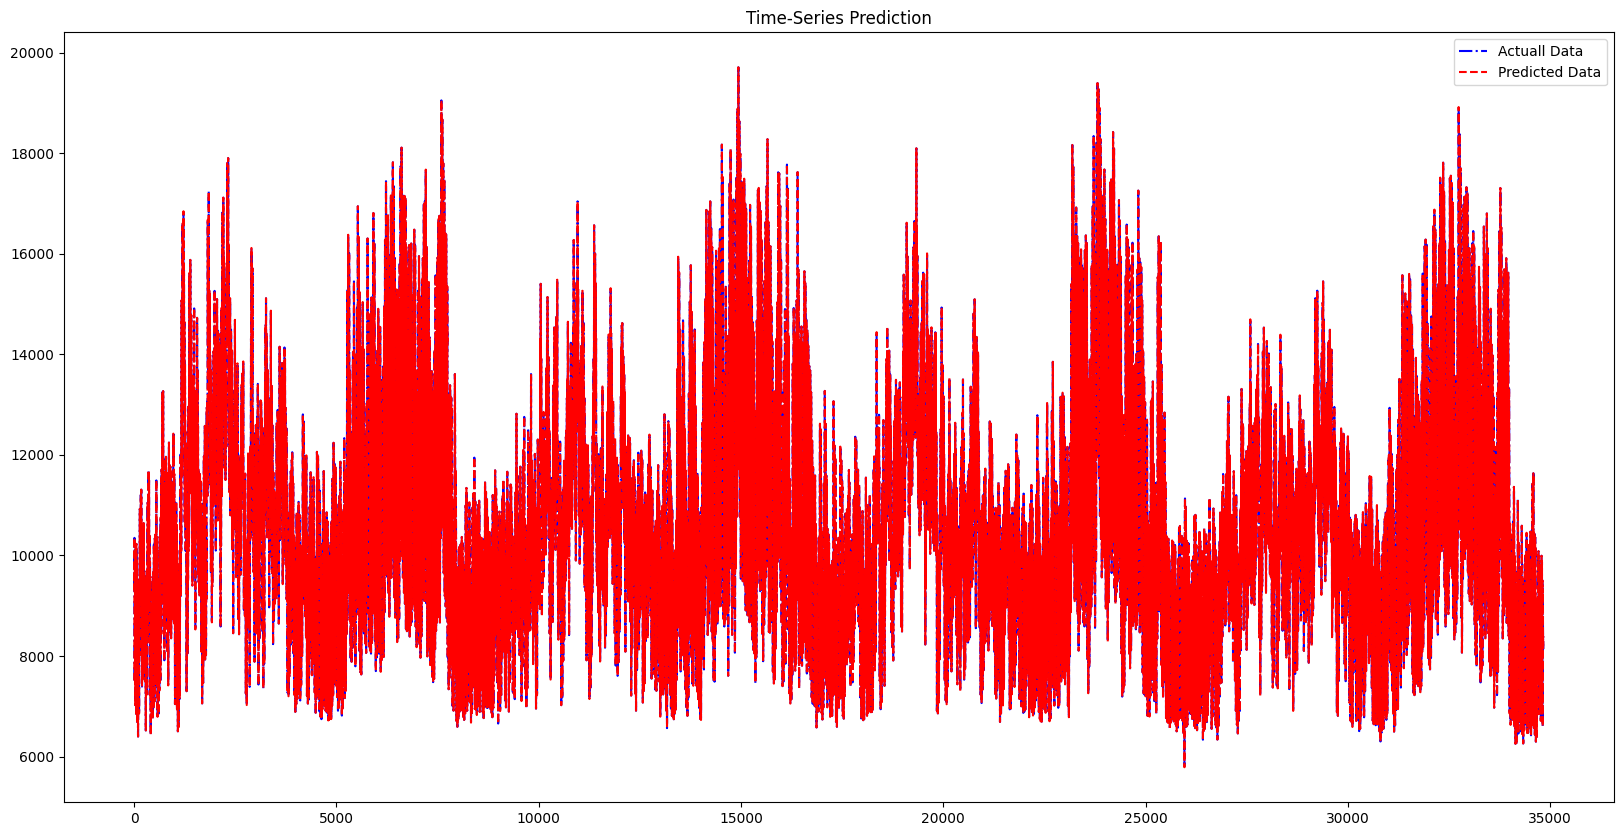

Test RMSE: 0.456


In [28]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real[-test_predict.size:], label='Actuall Data', c='b', linestyle='-.') #actual plot

plt.plot(y_hat[-test_predict.size:], label='Predicted Data',  c='r', linestyle='--') #predicted plot

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_real[-test_predict.size:], y_hat[-test_predict.size:]))
print('Test RMSE: %.3f' % rmse)

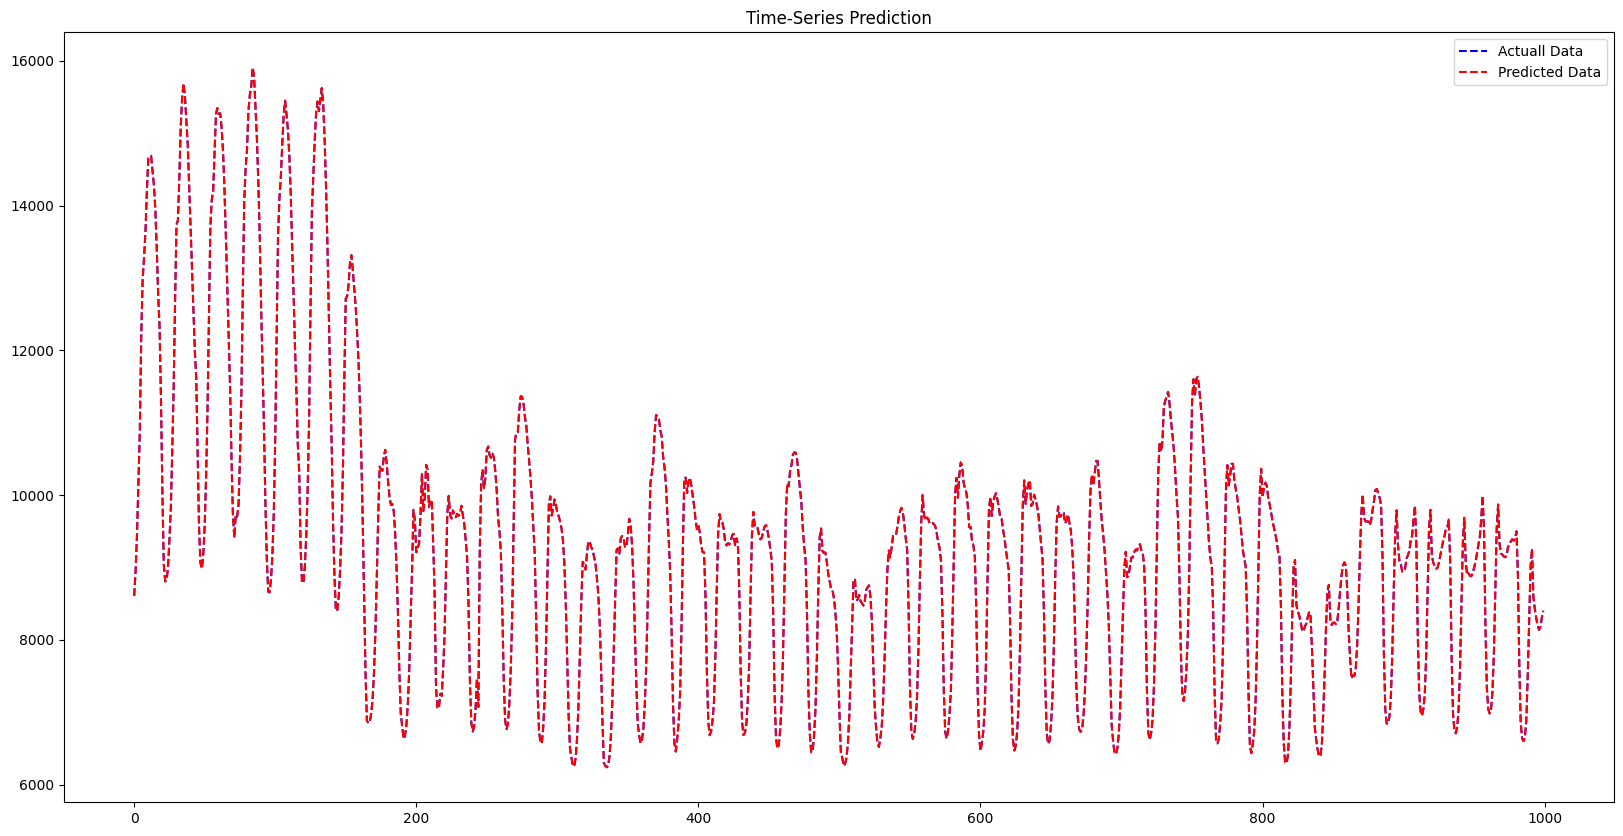

Test RMSE: 0.389


In [30]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real[-1000:], label='Actuall Data', c='b', linestyle='--') #actual plot

plt.plot(y_hat[-1000:], label='Predicted Data',  c='r', linestyle='--') #predicted plot

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_real[-1000:], y_hat[-1000:]))
print('Test RMSE: %.3f' % rmse)

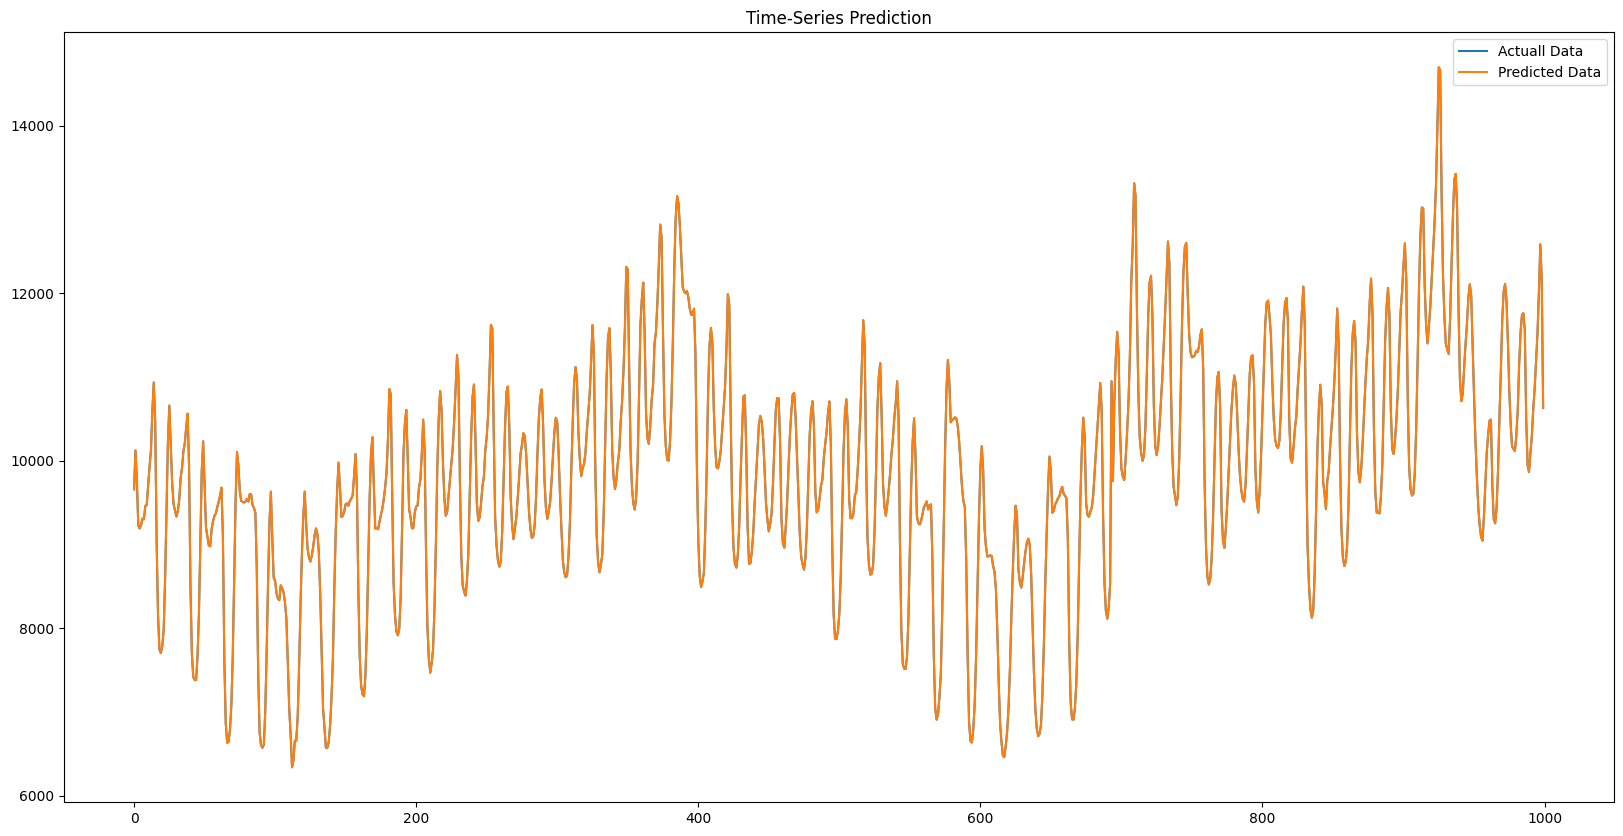

Test RMSE: 0.476


In [ ]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real[-1000:], label='Actuall Data') #actual plot

plt.plot(y_hat[-1000:], label='Predicted Data') #predicted plot

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_real[-1000:], y_hat[-1000:]))
print('Test RMSE: %.3f' % rmse)

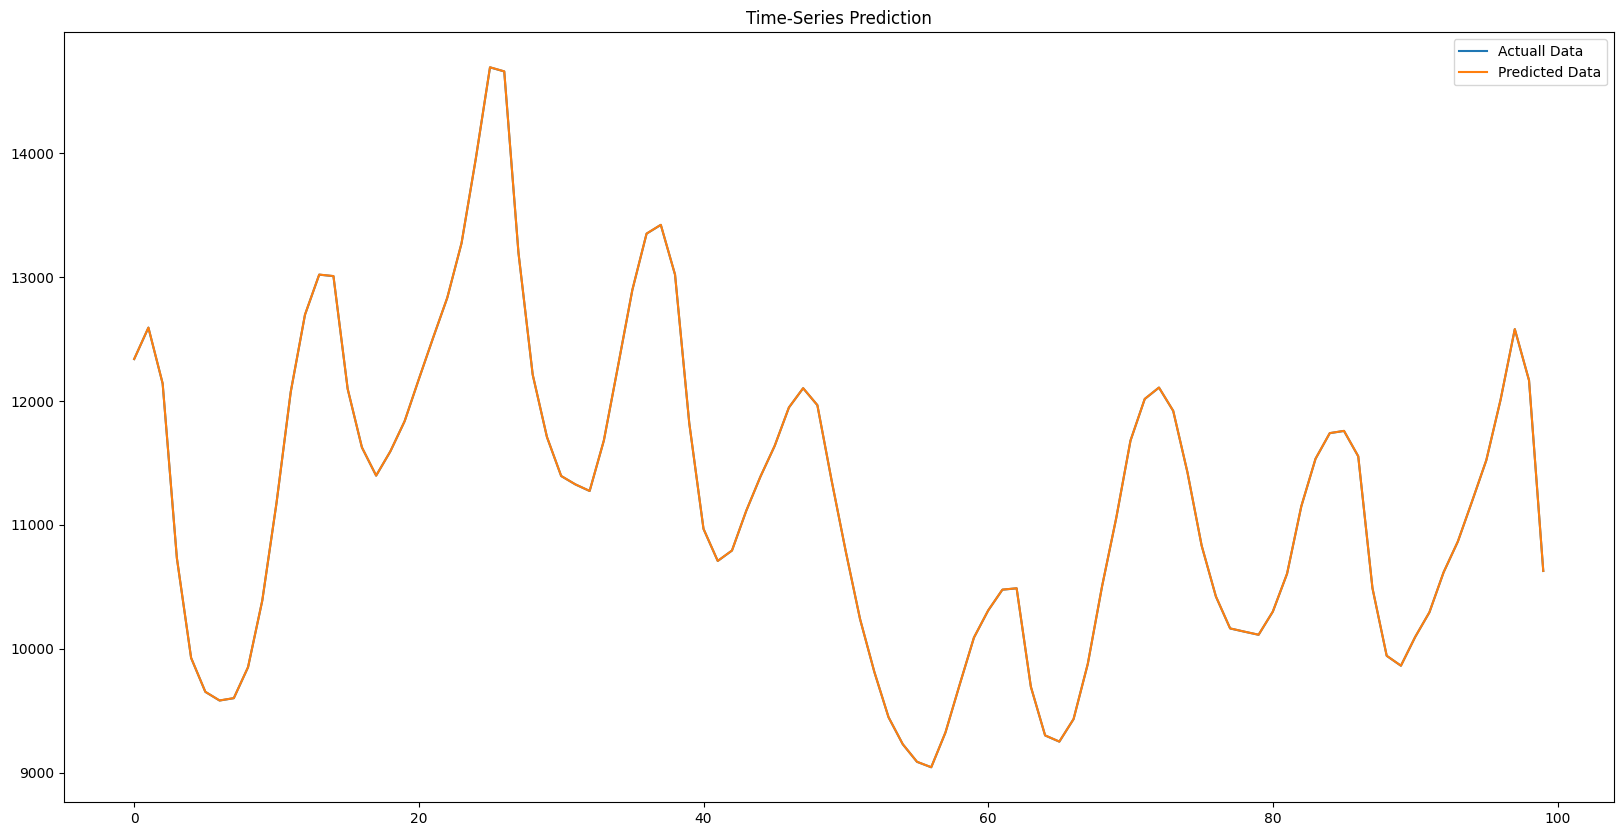

Test RMSE: 0.534


In [ ]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real[-100:], label='Actuall Data') #actual plot

plt.plot(y_hat[-100:], label='Predicted Data') #predicted plot

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_real[-100:], y_hat[-100:]))
print('Test RMSE: %.3f' % rmse)